## Explain an Intermediate Layer of VGG16 on ImageNet
Explaining a prediction in terms of the original input image is harder than explaining the predicition in terms of a higher convolutional layer (because the higher convolutional layer is closer to the output). This notebook gives a simple example of how to use GradientExplainer to do explain a model output with respect to the 7th layer of the pretrained VGG16 network.

Note that by default 200 samples are taken to compute the expectation. To run faster you can lower the number of samples per explanation.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import get_session
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
tf.compat.v1.disable_v2_behavior()
import shap
import tensorflow.keras.backend as K
import json


# HACK: TODO: 
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Instructions for updating:
non-resource variables are not supported in the long term


In [14]:
# HACKING

def dcnn_resnet(model_config, input_shape, metrics, n_classes=2, output_bias=None, gpus=1):
    '''
    Defines a deep convolutional neural network model for multiclass X-ray classification.
    :param model_config: A dictionary of parameters associated with the model architecture
    :param input_shape: The shape of the model input
    :param metrics: Metrics to track model's performance
    :return: a Keras Model object with the architecture defined in this method
    '''
    
    from tensorflow.keras import Sequential, Model
    from tensorflow.keras.layers import Dense, Dropout, Input, MaxPool2D, Conv2D, Flatten, LeakyReLU, BatchNormalization, \
        Activation, concatenate, GlobalAveragePooling2D
    from tensorflow.keras.regularizers import l2
    from tensorflow.keras.optimizers import Adam, SGD
    from tensorflow.keras.initializers import Constant
    from tensorflow.keras.applications.resnet_v2 import ResNet50V2, ResNet101V2
    from tensorflow.keras.utils import multi_gpu_model

    # Set hyperparameters
    nodes_dense0 = model_config['NODES_DENSE0']
    lr = model_config['LR']
    dropout = model_config['DROPOUT']
    l2_lambda = model_config['L2_LAMBDA']
    if model_config['OPTIMIZER'] == 'adam':
        optimizer = Adam(learning_rate=lr)
    elif model_config['OPTIMIZER'] == 'sgd':
        optimizer = SGD(learning_rate=lr)
    else:
        optimizer = Adam(learning_rate=lr)  # For now, Adam is default option
    init_filters = model_config['INIT_FILTERS']
    filter_exp_base = model_config['FILTER_EXP_BASE']
    conv_blocks = model_config['CONV_BLOCKS']
    kernel_size = eval(model_config['KERNEL_SIZE'])
    max_pool_size = eval(model_config['MAXPOOL_SIZE'])
    strides = eval(model_config['STRIDES'])

    # Set output bias
    if output_bias is not None:
        output_bias = Constant(output_bias)
    print("MODEL CONFIG: ", model_config)

    # Input layer
    X_input = Input(input_shape)
    X = X_input

    # Add convolutional (residual) blocks
    for i in range(conv_blocks):
        X_res = X
        X = Conv2D(init_filters * (filter_exp_base ** i), kernel_size, strides=strides, padding='same',
                         kernel_initializer='he_uniform', activity_regularizer=l2(l2_lambda),
                         name='conv' + str(i) + '_0')(X)
        X = BatchNormalization()(X)
        X = LeakyReLU()(X)
        X = Conv2D(init_filters * (filter_exp_base ** i), kernel_size, strides=strides, padding='same',
                         kernel_initializer='he_uniform', activity_regularizer=l2(l2_lambda),
                         name='conv' + str(i) + '_1')(X)
        X = concatenate([X, X_res], name='concat' + str(i))
        X = BatchNormalization()(X)
        X = LeakyReLU()(X)
        X = MaxPool2D(max_pool_size, padding='same')(X)

    # Add fully connected layers
    X = Flatten()(X)
    X = Dropout(dropout)(X)
    X = Dense(nodes_dense0, kernel_initializer='he_uniform', activity_regularizer=l2(l2_lambda))(X)
    X = LeakyReLU()(X)
    X = Dense(n_classes, bias_initializer=output_bias)(X)
    Y = Activation('softmax', dtype='float32', name='output')(X)

    # Set model loss function, optimizer, metrics.
    model = Model(inputs=X_input, outputs=Y)
    model.summary()
    if gpus >= 2:
        model = multi_gpu_model(model, gpus=gpus)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=metrics)
    return model


In [16]:
from tensorflow import keras
import yaml

cfg = yaml.full_load(open("config.yml", 'r'))
input_shape = cfg['DATA']['IMG_DIM'] + [3]
thresholds = 1.0 / len(cfg['DATA']['CLASSES'])
covid_class_idx = 0
n_classes = 2
output_bias = [0.0, 0.0]
num_gpus = 1
#metrics = [CategoricalAccuracy(name='accuracy'), # TODO: Paul
#           Precision(name='precision', thresholds=thresholds, class_id=covid_class_idx),
#           Recall(name='recall', thresholds=thresholds, class_id=covid_class_idx),
#           AUC(name='auc'),
#           F1Score(name='f1score', thresholds=thresholds, class_id=covid_class_idx)]

metrics = None
model = dcnn_resnet(cfg['NN']['DCNN_BINARY'], input_shape, metrics, 2, output_bias=output_bias, gpus=num_gpus)

model.load_weights('models/model.h5')


MODEL CONFIG:  {'KERNEL_SIZE': '(3,3)', 'STRIDES': '(1,1)', 'INIT_FILTERS': 16, 'FILTER_EXP_BASE': 3, 'MAXPOOL_SIZE': '(2,2)', 'CONV_BLOCKS': 3, 'NODES_DENSE0': 128, 'LR': 1e-05, 'OPTIMIZER': 'adam', 'DROPOUT': 0.4, 'L2_LAMBDA': 0.0001}
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv0_0 (Conv2D)                (None, 224, 224, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 224, 224, 16) 64          conv0_0[0][0]                    
_____________________________________________________

In [18]:
# load pre-trained model and choose two images to explain
# model = VGG16(weights='imagenet', include_top=True)


X,y = shap.datasets.imagenet50()
to_explain = X[[39,41]]
# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)


In [19]:
# explain how the input to the 7th layer of the model explains the top two classes
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return tf.compat.v1.keras.backend.get_session().run(model.layers[layer].input, feed_dict)

Using TensorFlow backend.


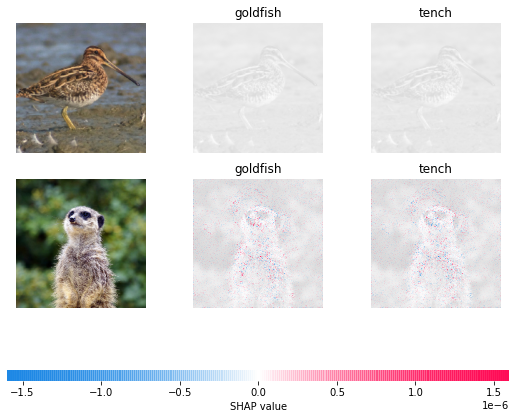

In [20]:
e = shap.GradientExplainer((model.layers[7].input, model.layers[-1].output), map2layer(preprocess_input(X.copy()), 7))
shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=2)
# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)
# plot the explanations
shap.image_plot(shap_values, to_explain, index_names)

## Explain with local smoothing
Gradient explainer uses expected gradients, which merges ideas from integrated gradients, SHAP, and SmoothGrad into a single expection equation. To use smoothing like SmoothGrad just set the local_smoothing parameter to something non-zero. This will add normally distributed noise with that standard deviation to the input during the expectation calculation. It can create smoother feature attributions that better capture correlated regions of the image.

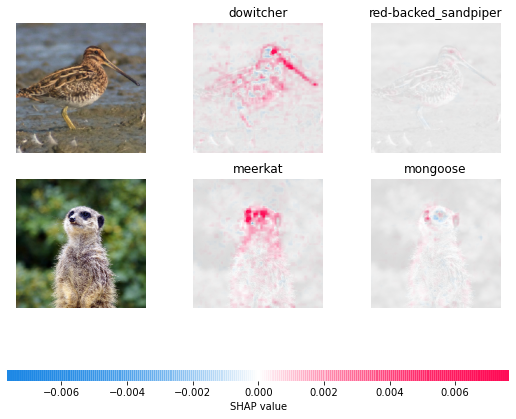

In [5]:
# explain how the input to the 7th layer of the model explains the top two classes
explainer = shap.GradientExplainer(
    (model.layers[7].input, model.layers[-1].output),
    map2layer(preprocess_input(X.copy()), 7),
    local_smoothing=100
)
shap_values,indexes = explainer.shap_values(map2layer(to_explain, 7), ranked_outputs=2)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap.image_plot(shap_values, to_explain, index_names)